
Model Evaluation Metrics:
Mean Absolute Error (MAE): 1024.21
Mean Squared Error (MSE): 1410911.62
Root Mean Squared Error (RMSE): 1187.82
Mean Absolute Percentage Error (MAPE): 22.10%


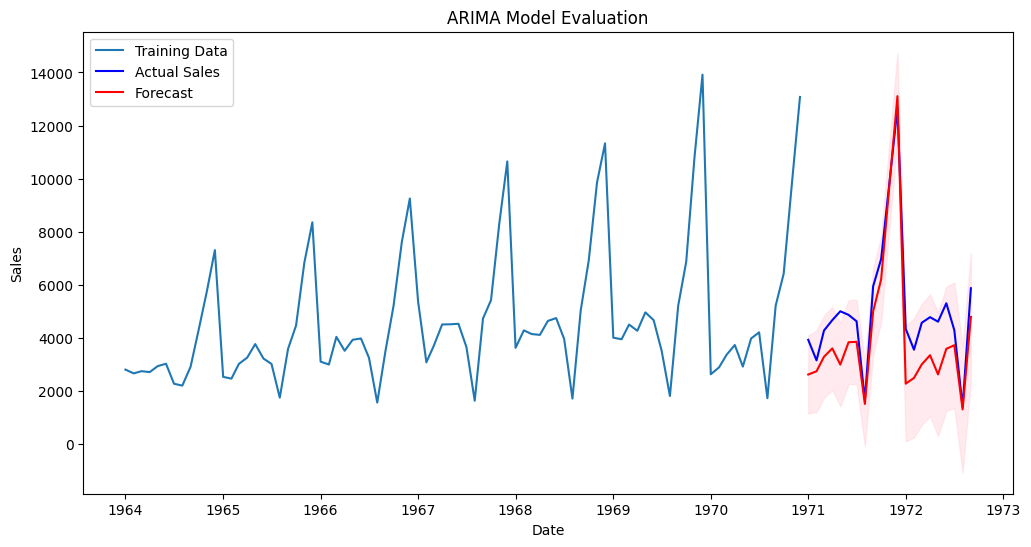

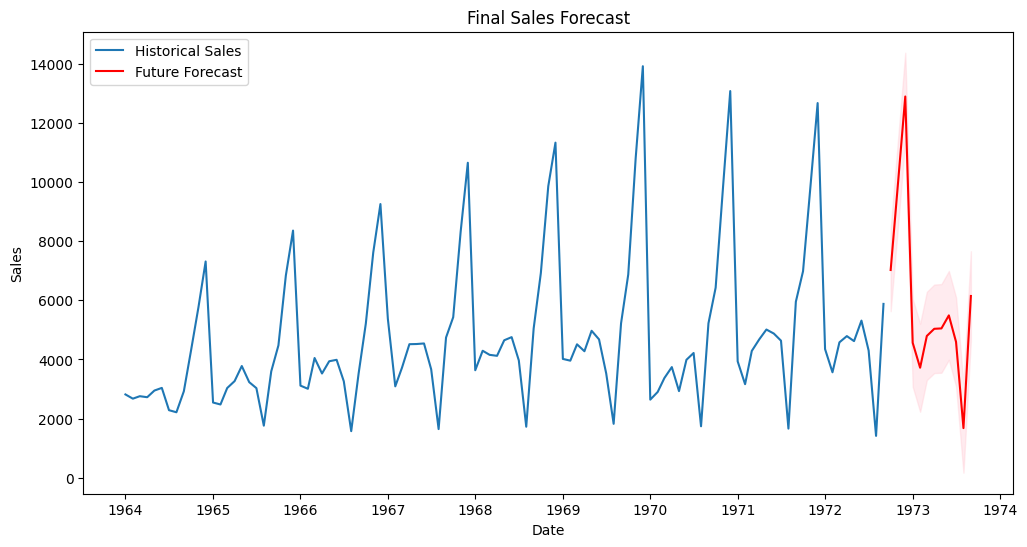

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import warnings
from math import sqrt
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("/content/perrin-freres-monthly-champagne-.csv")
df.columns = ['Month', 'Sales']

# Clean data
df.drop(106, axis=0, inplace=True)
df.drop(105, axis=0, inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Train-test split (80-20 split)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit model on training data
model = ARIMA(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Forecast on test data
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Calculate evaluation metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

metrics = calculate_metrics(test['Sales'], forecast_values)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
print(f"Mean Squared Error (MSE): {metrics['MSE']:.2f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")

# Visualize predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Training Data')
plt.plot(test.index, test['Sales'], label='Actual Sales', color='blue')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index,
                 confidence_intervals['lower Sales'],
                 confidence_intervals['upper Sales'],
                 color='pink', alpha=0.3)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Now train final model on full dataset for deployment
final_model = ARIMA(df['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
final_model_fit = final_model.fit()

# Save final model to pickle file
with open('/content/arima_model.pkl', 'wb') as f:
    pickle.dump(final_model_fit, f)

# Generate future forecast
forecast_steps = 12
future_forecast = final_model_fit.get_forecast(steps=forecast_steps)
future_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='MS')[1:]
future_forecast_df = pd.DataFrame({
    'Forecast': future_forecast.predicted_mean,
    'Confidence_Lower': future_forecast.conf_int()['lower Sales'],
    'Confidence_Upper': future_forecast.conf_int()['upper Sales']
}, index=future_index)

# Plot final forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Historical Sales')
plt.plot(future_forecast_df['Forecast'], label='Future Forecast', color='red')
plt.fill_between(future_forecast_df.index,
                 future_forecast_df['Confidence_Lower'],
                 future_forecast_df['Confidence_Upper'],
                 color='pink', alpha=0.3)
plt.title('Final Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()